<a href="https://colab.research.google.com/github/sepehr21ar/Deep_Learning_Project/blob/main/video_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import cv2  as cv
import  numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# https://drive.usercontent.google.com/open?id=1F2PN4eEaACAMJGbcDLSiCmQe8lT2Y3um&authuser=0

In [2]:
!gdown --id 1F2PN4eEaACAMJGbcDLSiCmQe8lT2Y3um

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1F2PN4eEaACAMJGbcDLSiCmQe8lT2Y3um
From (redirected): https://drive.google.com/uc?id=1F2PN4eEaACAMJGbcDLSiCmQe8lT2Y3um&confirm=t&uuid=2e6bbb8f-0dbd-4837-9d6a-24d9a2c9941d
To: /content/UCF101 Dataset.zip
100% 435M/435M [00:10<00:00, 40.5MB/s]


In [5]:
!unzip -q "/content/UCF101 Dataset.zip" -d train


In [8]:
train_videos_path = '/content/train/train'
test_videos_path = '/content/train/test'

train_labels = pd.read_csv('/content/train/train.csv')
test_labels = pd.read_csv('/content/train/test.csv')


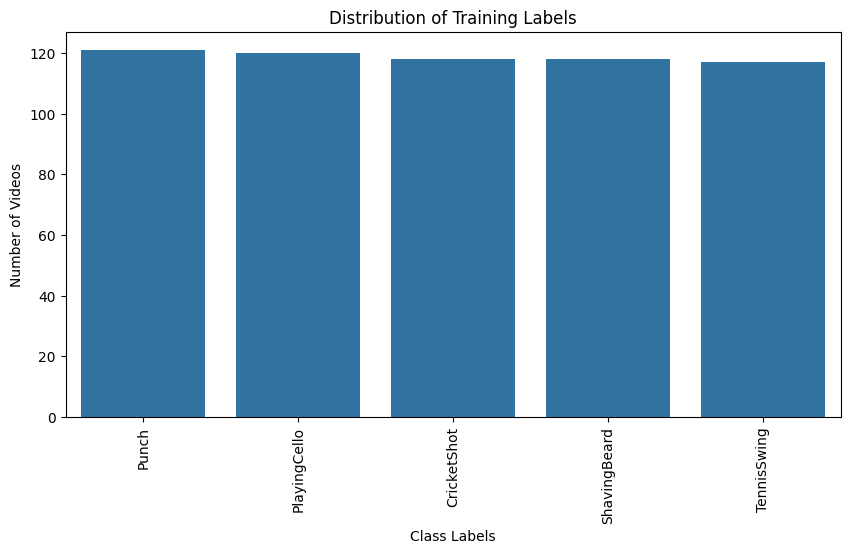

In [9]:
class_counts = train_labels['tag'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Training Labels')
plt.xlabel('Class Labels')
plt.ylabel('Number of Videos')
plt.xticks(rotation=90)
plt.show()

In [10]:
num_classes = train_labels['tag'].nunique()
print(f'Number of classes: {num_classes}')

Number of classes: 5


In [11]:
def extract_frames(video_path, num_frames=16):
    cap = cv.VideoCapture(video_path)
    frames = []

    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

    frame_interval = max(total_frames // num_frames, 1)

    for i in range(num_frames):
        cap.set(cv.CAP_PROP_POS_FRAMES, i * frame_interval)

        ret, frame = cap.read()

        if not ret:
            break
        frame = cv.resize(frame, (112, 112))

        frames.append(frame)

    cap.release()

    while len(frames) < num_frames:
        frames.append(np.zeros((112, 112, 3), np.uint8))

    return np.array(frames)

In [12]:
def load_data(labels, video_dir, num_classes, num_frames=16):

    X = []
    y = []

    for idx, row in tqdm(labels.iterrows(), total=labels.shape[0]):
        video_path = os.path.join(video_dir, row['video_name'])

        frames = extract_frames(video_path, num_frames)

        if len(frames) == num_frames:
            X.append(frames)
            y.append(row['tag'])

    X = np.array(X)

    y = to_categorical(pd.factorize(y)[0], num_classes)

    return X, y

X_train, y_train = load_data(train_labels, train_videos_path, num_classes)
X_test, y_test = load_data(test_labels, test_videos_path, num_classes)

100%|██████████| 594/594 [01:45<00:00,  5.62it/s]
<ipython-input-12-bc050f709a79>:17: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  y = to_categorical(pd.factorize(y)[0], num_classes)
100%|██████████| 224/224 [00:39<00:00,  5.71it/s]


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [19]:
def create_advanced_3dcnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv3D(64, (4, 4, 4), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(BatchNormalization())

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(BatchNormalization())

    model.add(Conv3D(256, (2, 2, 2), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (16, 112, 112, 3)
model = create_advanced_3dcnn_model(input_shape, num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [21]:

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=8, callbacks=[early_stopping, reduce_lr])

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - accuracy: 0.5965 - loss: 23.1434 - val_accuracy: 0.2773 - val_loss: 1822.4208 - learning_rate: 0.0010
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.8595 - loss: 11.6933 - val_accuracy: 0.3866 - val_loss: 439.0095 - learning_rate: 0.0010
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.8461 - loss: 13.2016 - val_accuracy: 0.6387 - val_loss: 144.5613 - learning_rate: 0.0010
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.9081 - loss: 6.8861 - val_accuracy: 0.8319 - val_loss: 23.0183 - learning_rate: 0.0010
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.9486 - loss: 4.3663 - val_accuracy: 0.7143 - val_loss: 164.5035 - learning_rate: 0.0010
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.9625 - loss: 2.3219 - val_accuracy: 0.9160 - val_loss: 25.1555 - learning_rate: 0.0010
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.9

In [22]:
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.5336 - loss: 98.5490
Test Accuracy: 0.61


In [25]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true_classes = np.argmax(y_test, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

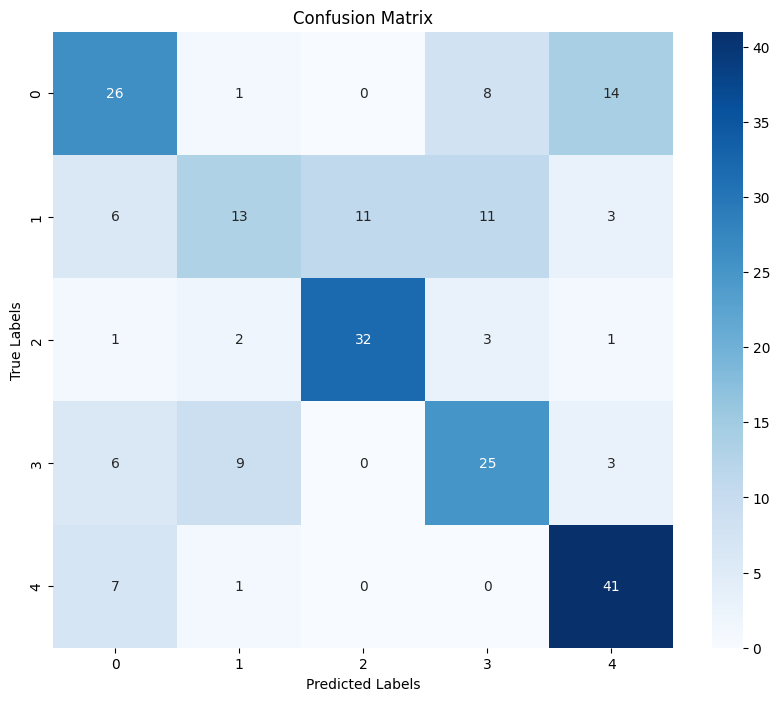

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [28]:
class_report = classification_report(y_true_classes, y_pred_classes, target_names=train_labels['tag'].unique())
print(class_report)

              precision    recall  f1-score   support

 CricketShot       0.57      0.53      0.55        49
PlayingCello       0.50      0.30      0.37        44
       Punch       0.74      0.82      0.78        39
ShavingBeard       0.53      0.58      0.56        43
 TennisSwing       0.66      0.84      0.74        49

    accuracy                           0.61       224
   macro avg       0.60      0.61      0.60       224
weighted avg       0.60      0.61      0.60       224



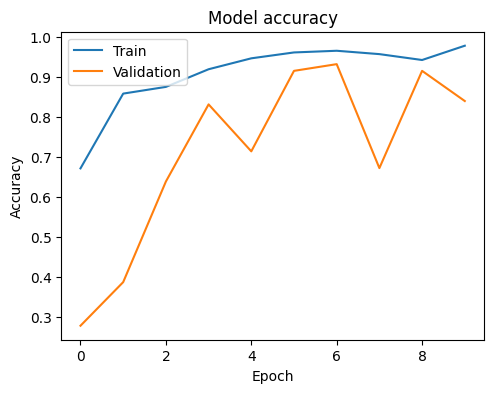

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

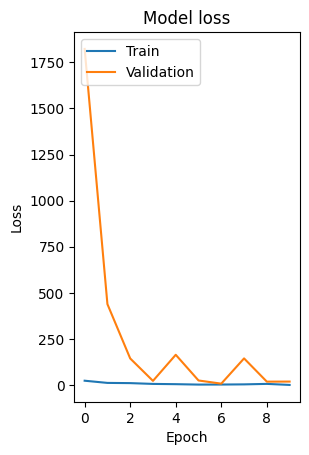

In [30]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()